# Graphene and Kane-Mele model

We are going to:
* Deal with 2D band structures
* Use a more general lattice (honeycomb lattice of graphene)
* Construct the very first topological insulator
* Learn about topological protection in presence of time-reversal symmetry

*Parts of this tutorial are based on the [online course on topology in condensed matter](http://topocondmat.org)*

In [32]:
# We'll have 3D plotting and 2D band structure, so we need a handful of helper functions.
#%run matplotlib_setup.ipy

from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np

import kwant
from wraparound import wraparound


def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200, _figsize=(8,8), dpi=196):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = pyplot.figure(figsize=_figsize, dpi=dpi)
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    axes.view_init(15, 60)
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap=matplotlib.cm.RdBu_r, vmin=emin, vmax=emax,
                          linewidth=0.1)

## Graphene

Quantum Hall effect creates protected edge states using a strong magnetic field. Another way to create those is to start from a system with Dirac cones, and open gaps in those.

There is a real (and a very important) two-dimensional system which has Dirac cones: [graphene](http://en.wikipedia.org/wiki/Graphene). So in this chapter we will take graphene and make it into a topological system with chiral edge states.

Graphene is a single layer of carbon atoms arranged in a honeycomb lattice. It is a triangular lattice with two atoms per unit cell, type $A$ and type $B$, represented by red and blue sites in the figure:

![](images/graphene_lattice.svg)

In [13]:
graphene = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],  # lattice vectors
                                 [[0, 0], [0, 1/np.sqrt(3)]])   # Coordinates of the sites
a, b = graphene.sublattices

We now create a `Builder` with the translational symmetries of graphene, and calculate the bulk dispersion of graphene.

Hence, the wave function in a unit cell can be written as a vector $(\Psi_A, \Psi_B)^T$ of amplitudes on the two sites $A$ and $B$. Taking a simple tight-binding model where electrons can hop between neighboring sites with hopping strength $t$, one obtains the Bloch Hamiltonian:

$$
H_0(\mathbf{k})= \begin{pmatrix} 0 & h(\mathbf{k}) \\ h^\dagger(\mathbf{k}) & 0 \end{pmatrix}\,,
$$

with $\mathbf{k}=(k_x, k_y)$ and

$$h(\mathbf{k}) = t_1\,\sum_i\,\exp\,\left(i\,\mathbf{k}\cdot\mathbf{a}_i\right)\,.$$

Here $\mathbf{a}_i$ are the three vectors in the figure, connecting nearest neighbors of the lattice [we set the lattice spacing to one, so that for instance $\mathbf{a}_1=(1,0)$].  Introducing a set of Pauli matrices $\sigma$ which act on the sublattice degree of freedom, we can write the Hamiltonian in a compact form as

$$H_0(\mathbf{k}) = t_1\,\sum_i\,\left[\sigma_x\,\cos(\mathbf{k}\cdot\mathbf{a}_i)-\sigma_y \,\sin(\mathbf{k}\cdot\mathbf{a}_i)\right]\,.$$

The energy spectrum $E(\mathbf{k}) = \pm \,\left|h(\mathbf{k})\right|$ gives rise to the famous band structure of graphene, with the two bands touching at the six corners of the Brillouin zone:

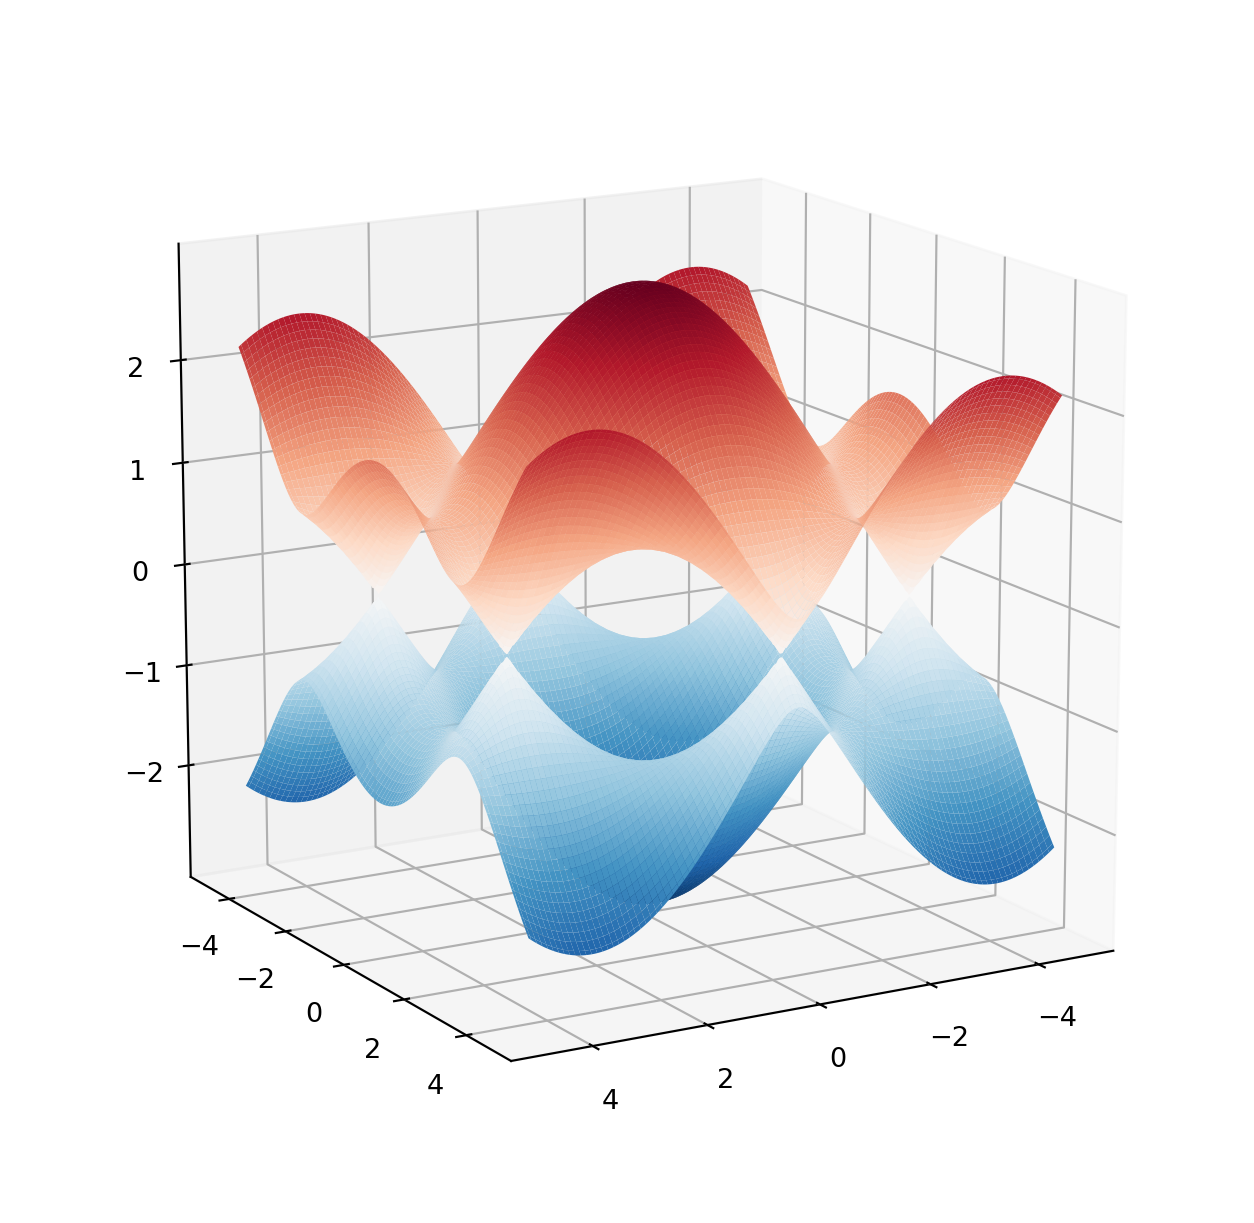

In [33]:
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1

dispersion_2D(wraparound(bulk_graphene).finalized())

Let's also create 1D ribbons of graphene.

There are two nontrivial directions: armchair and zigzag

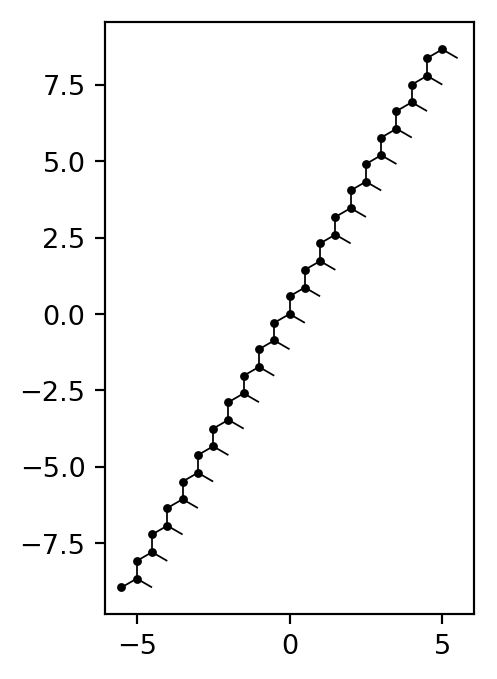

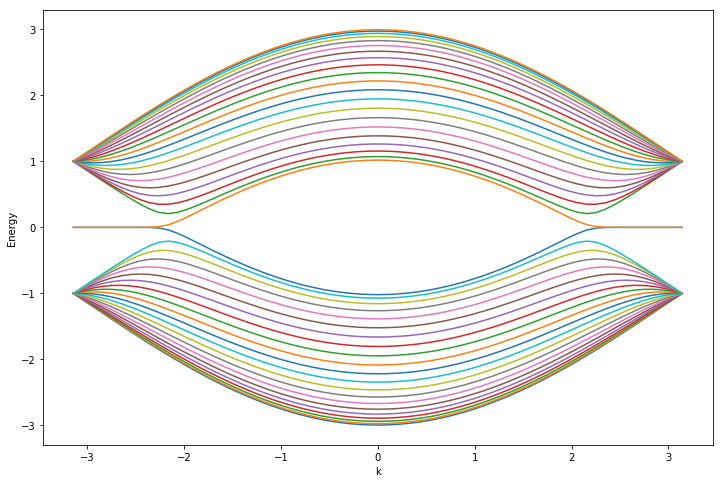

In [50]:
zigzag_ribbon = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
zigzag_ribbon[graphene.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = 0
zigzag_ribbon[graphene.neighbors(1)] = 1

kwant.plotter.plot(zigzag_ribbon, dpi=196);
kwant.plotter.bands(zigzag_ribbon.finalized(), fig_size=(12, 8));

#### Your turn!

*Calculate a dispersion of an armchair nanoribbon. You'll need to figure out what is its period.*

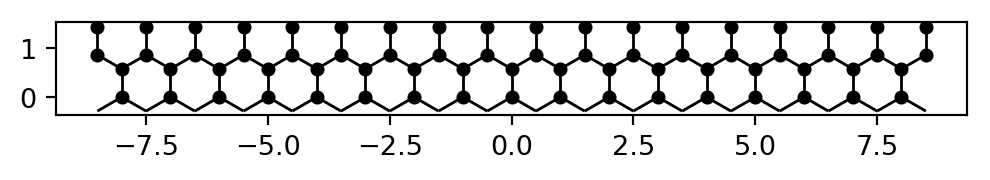

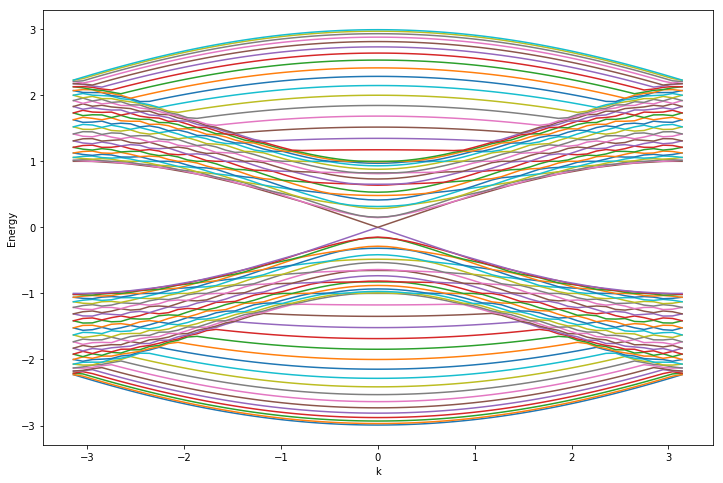

In [51]:
# Solution
armchair_ribbon = kwant.Builder(kwant.TranslationalSymmetry([0, np.sqrt(3)]))
armchair_ribbon[graphene.shape((lambda pos: abs(pos[0]) < 9), (0, 0))] = 0
armchair_ribbon[graphene.neighbors(1)] = 1

kwant.plotter.plot(armchair_ribbon, dpi=196);
kwant.plotter.bands(armchair_ribbon.finalized(), fig_size=(12, 8));

#### Your turn!

Add potentials of opposite sign to the zigzag nanoribbon, and see what happens to the dispersion relation.

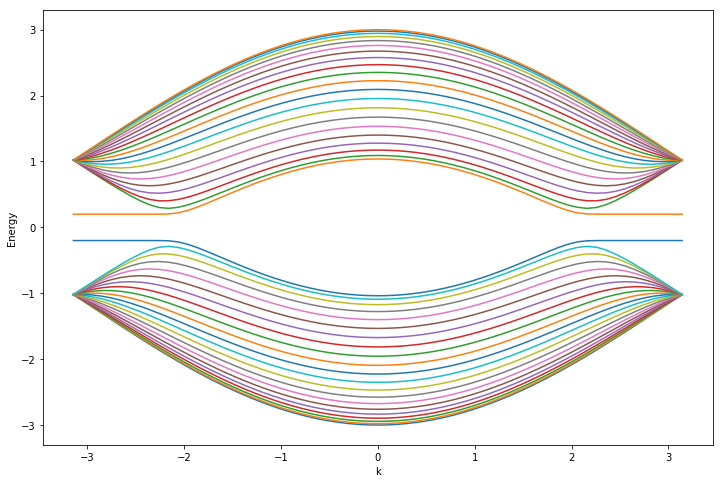

In [38]:
# Solution
zigzag_ribbon = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
zigzag_ribbon[a.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = 0.2
zigzag_ribbon[b.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = -0.2
zigzag_ribbon[graphene.neighbors(1)] = 1

kwant.plotter.bands(zigzag_ribbon.finalized(), fig_size=(12, 8));

We have now opened a gap, but there are no protected states inside it.

## Haldane model of anomalous quantum Hall effect

The more interesting way to open the gap in graphene dispersion is introduced by Duncan Haldane, [Phys. Rev. Lett. **61**, 2015 (1988)](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.61.2015)

The idea of this model is to break inversion symmetry that protects the Dirac points by adding next-nearest neighbor hoppings

![](images/haldane_hoppings.svg)

In [52]:
nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b

In [53]:
def nnn_hopping(site1, site2, params):
    return 1j * params.t_2

def onsite(site, params):
    return params.m * (1 if site.family == a else -1)

def add_hoppings(syst):
    syst[graphene.neighbors(1)] = 1
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping

haldane = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
haldane[graphene.shape((lambda pos: True), (0, 0))] = onsite
haldane[graphene.neighbors(1)] = 1
haldane[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping

@interact(t_2=(0, .08, .01))
def qshe_dispersion(t_2=0, m=.2):
    dispersion_2D(wraparound(haldane).finalized(), [SimpleNamespace(t_2=t_2, m=m)], num_points=100)

interactive(children=(FloatSlider(value=0.0, description='t_2', max=0.08, step=0.01), FloatSlider(value=0.2, d…

Now we see that the gap closes in one of the Dirac cones, and does not close in the other half. Let's see what this means for the dispersion relation in a ribbon.

#### Your turn!

*Plot a dispersion of either nanoribbon, and see what happens to the edge states*

In [48]:
# Solution
def nnn_hopping(site1, site2, params):
    return 1j * params.t_2

def onsite(site, params):
    return params.m * (1 if site.family == a else -1)

def add_hoppings(syst):
    syst[graphene.neighbors(1)] = 1
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping

zigzag_haldane = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
zigzag_haldane[graphene.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = onsite
zigzag_haldane[graphene.neighbors(1)] = 1
zigzag_haldane[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping

@interact(t_2=(0, .08, .01))
def qshe_dispersion(t_2=0, m=.2):
    kwant.plotter.bands(zigzag_haldane.finalized(), [SimpleNamespace(t_2=t_2, m=m)], fig_size=(12, 8))

interactive(children=(FloatSlider(value=0.0, description='t_2', max=0.08, step=0.01), FloatSlider(value=0.2, d…

## Quantum spin Hall effect in Kane-Mele model

(Following: C.L. Kane and E.J. Mele, Phys. Rev. Lett. **95**, 226801 (2005))

Haldane model breaks time-reversal symmetry and inversion symmetry. Lattice-scale hoppings that break time-reversal symmetry do not appear in non-magnetic materials. We can make the Hamiltonian invariant under inversion and time-reversal by making the next-nearest neighbor hoppings spin-dependent.

So if we take those hoppings equal to $i t_2 \sigma_z$, we get teh 

In [42]:
# Pauli matrices 
s0 = np.identity(2)
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.diag([1, -1])

In [43]:
def spin_orbit(site1, site2, params):
    return 1j * params.t_2 * sz

def onsite(site, params):
    return s0 * params.m * (1 if site.family == a else -1)

def add_hoppings(syst):
    syst[graphene.neighbors(1)] = s0
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = spin_orbit

In [44]:
bulk_kane_mele = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_kane_mele[graphene.shape((lambda pos: True), (0, 0))] = onsite
add_hoppings(bulk_kane_mele)

@interact(t_2=(0, .3, .01))
def qshe_dispersion(t_2=0, m=.2):
    dispersion_2D(wraparound(bulk_kane_mele).finalized(), [SimpleNamespace(t_2=t_2, m=m)], num_points=100)

interactive(children=(FloatSlider(value=0.0, description='t_2', max=0.3, step=0.01), FloatSlider(value=0.2, de…

In [46]:
zigzag_kane_mele = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
zigzag_kane_mele[graphene.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = onsite
add_hoppings(zigzag_kane_mele)

@interact(t_2=(0, .12, .01))
def qshe_zigzag_dispersion(t_2=0, m=.2):
    kwant.plotter.bands(zigzag_kane_mele.finalized(), [SimpleNamespace(t_2=t_2, m=m)], fig_size=(12, 8))

interactive(children=(FloatSlider(value=0.0, description='t_2', max=0.12, step=0.01), FloatSlider(value=0.2, d…

### Robustness of quantum spin Hall effect

We have an open important question: what protects these new edge states? Is it spin conservation? If we don't break the conservation of $\sigma_z$, then it is obvious that the edge states don't disappear (we have two copies of Haldane model after all).

The most interesting property of the quantum spin Hall effect is that it does not rely on any conservation law. The reason for this is [Kramers degeneracy](https://en.wikipedia.org/wiki/Kramers_theorem), that prevents two states that are time-reversal partners of each other from coupling to each other.

As a final test of topological protection, let's add an extra parameter that breaks spin conservation and check what happens to the edge states.

#### Your turn!

Add a small perturbation proportional to $i \sigma_x$ or $i \sigma_y$ to some hopping. Check how the dispersion changes.

In [47]:
# Solution

zigzag_kane_mele = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
zigzag_kane_mele[graphene.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = onsite
zigzag_kane_mele[graphene.neighbors(1)] = s0
zigzag_kane_mele[kwant.builder.HoppingKind((0, 0), b, a)] = s0 + 0.3j * sx
zigzag_kane_mele[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = spin_orbit

@interact(t_2=(0, .12, .01))
def qshe_zigzag_dispersion(t_2=0, m=.2):
    kwant.plotter.bands(zigzag_kane_mele.finalized(), [SimpleNamespace(t_2=t_2, m=m)], fig_size=(12, 8))

interactive(children=(FloatSlider(value=0.0, description='t_2', max=0.12, step=0.01), FloatSlider(value=0.2, d…

### Self-study (takes more time)

Using the multiterminal conductance calculation, calculate what happens to $\sigma_{xx}$ and $\sigma_{xy}$ if you turn magnetic field on. What role does spin conservation play?

In [1]:
[2,3]+[4,5]

[2, 3, 4, 5]